# Calendar Aging Mechanism

<p align="center">
  <img src="../docs/figures/02_calendar_aging_predictor.png" alt="Calendar Aging Results" width="600"/>
</p>

The calendar aging mechanism in batteries refers to the degradation of battery performance over time, even when the battery is not actively cycled. This process is influenced by factors such as the State of Charge (SOC), storage duration, and the temperature at which the battery is stored.

During storage, several chemical reactions continue to occur within the battery, contributing to capacity loss. Key phenomena that drive calendar aging include the growth of the solid electrolyte interphase (SEI) layer on the anode, side reactions that consume active lithium, and the gradual breakdown of the electrolyte. These reactions tend to be accelerated by higher temperatures and higher states of charge, leading to faster degradation.

Temperature plays a particularly significant role in calendar aging. Elevated temperatures can increase the rate of unwanted chemical reactions, thereby speeding up the aging process. Similarly, storing a battery at a high state of charge can exacerbate these effects, resulting in a more rapid decline in capacity.

Accurate prediction and understanding of calendar aging are essential for optimizing battery lifespan and ensuring reliability, especially in applications where batteries spend significant time in storage or at partial states of charge. This notebook explores the calendar aging mechanism and applies probabilistic deep learning models to predict battery degradation, providing insights that can help manage and mitigate the effects of calendar aging.

## Environment Setup and Module Imports

In the following cell, we set up the environment for analyzing calendar aging in batteries. This involves configuring the system paths to include necessary directories, which allows us to import custom modules and scripts used throughout the notebook.

We also import TensorFlow Probability, which will be used for probabilistic modeling, and set up seaborn for data visualization. Finally, we ensure that all plots are displayed inline within the notebook for easy reference.

In [ ]:
import os
import sys
from pathlib import Path

myDir = os.getcwd()
sys.path.append(myDir)
path = Path(myDir)
parent=str(path.parent.absolute())
sys.path.append(parent)
sys.path.append(os.path.join(parent, "scripts"))

import tensorflow_probability as tfp

from src.common.utils import *
from src.lfp.calendar_aging import CalendarAging
sns.reset_defaults()
#sns.set_style('whitegrid')
#sns.set_context('talk')
sns.set_context(context='talk',font_scale=0.7)

%matplotlib inline

tfd = tfp.distributions
tfpl = tfp.layers

The following cell checks whether a GPU is available for TensorFlow to use.

In [12]:
if tf.test.gpu_device_name() != '/device:GPU:0':
  print('WARNING: GPU device not found.')
else:
  print('SUCCESS: Found GPU: {}'.format(tf.test.gpu_device_name()))

## Defining Paths for Models, Figures, and Normalizers

In the following cell, we define several paths that will be used throughout the notebook for accessing trained models, saving results, and retrieving normalizers. These paths ensure that the workflow is well-organized and that all relevant files are easily accessible.

- **Model Paths**: Paths to directories containing trained models for cycle and calendar aging are defined.
- **Figure Save Paths**: Paths are specified for saving figures related to the calendar aging analysis.
- **Normalizer Paths**: Paths to the normalizers used in cycle and calendar aging analysis are defined, which are essential for data preprocessing.

These paths will be used in subsequent cells to load models, save analysis results, and ensure data is properly preprocessed.

In [13]:
model_path = os.path.join(parent, "trained_models")
model_path_cycle = os.path.join(model_path, "cycle")
model_path_calendar = os.path.join(model_path, "calendar")
fig_save_path = os.path.join(parent, "results")
fig_save_path_calendar = os.path.join(os.path.join(fig_save_path, "calendar"), "figures")
normalizer_path_cycle = os.path.join(model_path_cycle, 'normalizer')
normalizer_path_calendar = os.path.join(model_path_calendar, 'normalizer')

## Importing and Normalizing Calendar Aging Data

The following cell imports and processes the calendar aging dataset from an [Excel file](https://data.mendeley.com/datasets/kxh42bfgtj/1). The data is cleaned by setting the first row as the column headers and dropping the original first row. The index is reset to ensure a consistent structure.

To prepare the data for analysis, the relevant columns (excluding the storage time) are normalized based on their maximum values, which scales the data to a common range for better comparability. The normalized dataset is then used for further analysis in the notebook, allowing us to explore the effects of calendar aging on battery capacity.

In [14]:
file_name_calendar = "DischargeCapacity.xlsx"
dir_calendar = os.path.join(parent, 'dataset', 'data_calendar')
file_path = os.path.join(dir_calendar, file_name_calendar)
df_calendar = pd.read_excel(file_path)
# Set the first row as the column names
df_calendar.columns = df_calendar.iloc[0]
# Drop the first row from the DataFrame
df_calendar = df_calendar.drop(df_calendar.index[0])
# Reset the index if necessary
df_calendar.reset_index(drop=True, inplace=True)
# Calculate the maximum value for each column, excluding 'C'
max_values = df_calendar.drop(columns=['Storage time / hours']).max()
# Normalize only selected columns by their maximum value
df_normalized = df_calendar.drop(columns=['Storage time / hours']) / max_values
# Add the excluded column back to the normalized DataFrame
df_normalized['Storage time / hours'] = df_calendar['Storage time / hours']
df_calendar = df_normalized
df_calendar

,"TP_0°C,50%SOC","TP_10°C,50%SOC","TP_25°C,0%SOC","TP_25°C,50%SOC","TP_25°C,100%SOC","TP_40°C,0%SOC","TP_40°C,12.5%SOC","TP_40°C,25%SOC","TP_40°C,37.5%SOC","TP_40°C,50%SOC","TP_40°C,62.5%SOC","TP_40°C,75%SOC","TP_40°C,87.5%SOC","TP_40°C,100%SOC","TP_60°C,0%SOC","TP_60°C,50%SOC","TP_60°C,100%SOC",Storage time / hours
0,1.0,1.0,0.997997,1.0,1.0,0.997901,0.997795,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0
1,0.998428,0.997259,1.0,0.997544,0.989326,1.0,1.0,0.997164,0.995723,0.997601,0.994064,0.988179,0.984,0.985778,0.999658,0.985402,0.974359,160.33
2,0.998257,0.996598,0.99897,0.997139,0.985785,0.999667,0.999192,0.995767,0.992797,0.994927,0.991269,0.983815,0.978986,0.980651,0.996774,0.977448,0.962975,276.98
3,0.997479,0.99594,0.998404,0.995879,0.982648,0.998734,0.997353,0.993838,0.990231,0.991939,0.98849,0.980829,0.974729,0.976254,0.993941,0.971162,0.954913,408.99
4,0.996627,0.994675,0.997967,0.993794,0.978755,0.997975,0.994928,0.990357,0.986372,0.987918,0.984051,0.976173,0.968484,0.969848,0.990393,0.960497,0.942445,708.11
5,0.995428,0.993684,0.99687,0.990195,0.973172,0.996605,0.993045,0.987872,0.98306,0.984484,0.980615,0.971944,0.963392,0.964528,0.987272,0.953378,0.933912,1009.1
6,0.994464,0.992705,0.995928,0.988508,0.970365,0.995302,0.991082,0.98584,0.980255,0.981454,0.977776,0.96877,0.959281,0.960187,0.984323,0.946895,0.926379,1285.6
7,0.993641,0.991386,0.994792,0.986529,0.966334,0.993934,0.98825,0.981977,0.975606,0.976736,0.972774,0.963458,0.952505,0.953223,0.981077,0.935966,0.913511,1945
8,0.99283,0.990007,0.993918,0.984635,0.961419,0.992392,0.985602,0.978683,0.971658,0.97272,0.96867,0.959023,0.946888,0.947425,0.977956,0.927217,0.903227,2579.2
9,0.99211,0.989199,0.993131,0.98289,0.956215,0.99097,0.982981,0.975563,0.967849,0.968755,0.964676,0.954855,0.941724,0.942132,0.975202,0.920554,0.895189,3286.7


## Initializing the CalendarAging Model

In the following cell, we initialize the `CalendarAging` class, which is a custom model designed to analyze the effects of calendar aging on batteries. The class is initialized with the following parameters:

- `load_trained_models=True`: Pre-trained models are loaded during initialization, allowing us to use these models directly for predictions and analysis without the need to retrain them. [Here](../trained_models/calendar), you can find a cycle aging model trained according to the full datasets provided by TUM-EES.
- `complete_data=False`: Only a subset of the data is loaded, which can be accessed by the public. We cannot share the full datasets provided by TUM-EES.

The `calendar_aging` object will be used in subsequent steps to manage and analyze the calendar aging data, leveraging the capabilities of the pre-trained models.

In [5]:
calendar_aging = CalendarAging(load_trained_models=True, complete_data=False)

Loading trained model from C:\Users\heidarah\PycharmProjects\battprodeep_public\trained_models\calendar\virtual_time.
Extracted model to temporary directory: C:\Users\heidarah\AppData\Local\Temp\tmpqib08i4k
Model directory: C:\Users\heidarah\AppData\Local\Temp\tmpqib08i4k
Model loaded from: C:\Users\heidarah\AppData\Local\Temp\tmpqib08i4k
Temporary directory deleted: C:\Users\heidarah\AppData\Local\Temp\tmpqib08i4k
Loaded model from: C:\Users\heidarah\PycharmProjects\battprodeep_public\trained_models\calendar\virtual_time\model_20240527_143351.zip
Loading trained model from C:\Users\heidarah\PycharmProjects\battprodeep_public\trained_models\calendar\deterministic.
Extracted model to temporary directory: C:\Users\heidarah\AppData\Local\Temp\tmpsvnosjig
Model directory: C:\Users\heidarah\AppData\Local\Temp\tmpsvnosjig
Model loaded from: C:\Users\heidarah\AppData\Local\Temp\tmpsvnosjig
Temporary directory deleted: C:\Users\heidarah\AppData\Local\Temp\tmpsvnosjig
Loaded model from: C:\User

## Preprocessing the Calendar Aging Data

In the following cell, we prepare the calendar aging data for analysis by passing it to the `preprocess_data` method of the `CalendarAging` model. The data is organized into a dictionary with the key `'calendar'`, which maps to the `df_calendar` DataFrame containing the relevant aging data.

The `preprocess_data` method will handle necessary preprocessing steps such as normalization, handling missing values, and preparing features. This ensures that the data is in the correct format and ready for subsequent analysis or modeling within the `CalendarAging` class.

In [6]:
data = {
    'calendar': df_calendar
}
calendar_aging.preprocess_data(data)

Preprocessing data.


## Generating and Saving Violin Plot of Feature Distributions

In the following cell, we generate a violin plot to visualize the distribution of features in the training data used for the `CalendarAging` model. The plot helps us understand the underlying patterns and densities of the data, which is crucial for analyzing how different features contribute to battery aging over time.

The plot is saved as an SVG file in the `results/calendar/figures/` directory. By setting `save_plot=True`, we ensure that the plot is stored for future reference or inclusion in reports, allowing for better documentation and analysis of the feature distributions related to calendar aging.

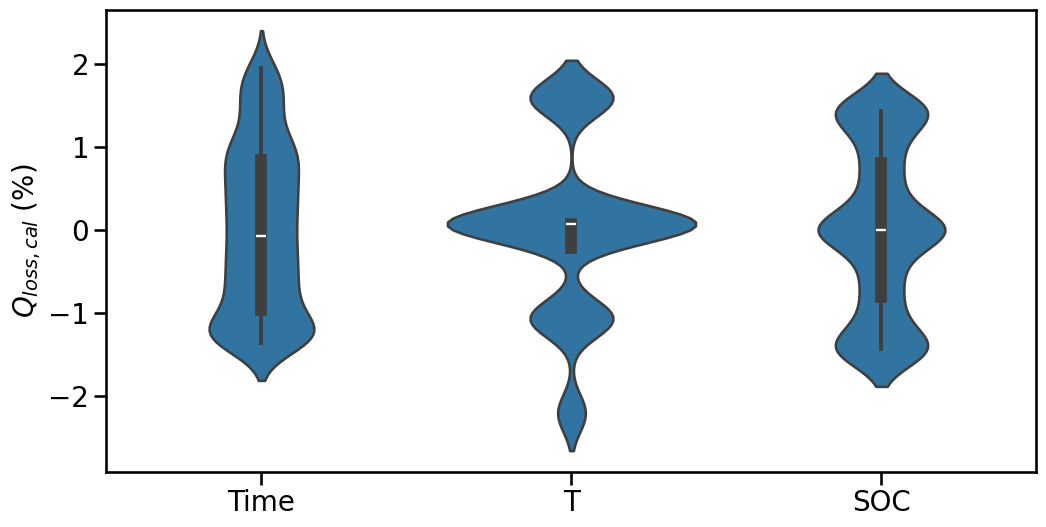

In [7]:
file_name = os.path.join(parent, "results/calendar/figures/violin_cycle.svg")
plot_feature_distributions(calendar_aging.df_train_inverse, type=calendar_aging.degradation_type, save_plot=True, save_path=file_name)

## Training the CalendarAging Model

In this cell, we train the `CalendarAging` model using the calendar aging dataset (`df_calendar`). The training process involves fitting the model to the data to learn the patterns and relationships between various features (such as temperature, state of charge, and storage duration) and the battery's degradation behavior over time.

In [ ]:
# Training the model
calendar_aging.train(df_calendar, is_virtual=False)

## Training the Virtual Time Predictor Model

In this cell, we train the `CalendarAging` model with a focus on predicting "virtual time". Virtual time is a theoretical construct used to map the effects of accelerated aging conditions (such as high temperatures or high states of charge) to equivalent aging under normal conditions.

The model is trained using the calendar aging dataset (`df_calendar`) with `is_virtual=True`, indicating that it should learn to predict virtual time. After training, we retrieve the trained virtual time model, which will be used to make predictions about battery aging that are relevant to real-world usage scenarios.

In [ ]:
# Training the virtual time predictor model
calendar_aging.train(df_calendar, is_virtual=True)
virtual_time_model = calendar_aging.model_virtual

## Making Predictions on Battery Capacity Loss with CalendarAging Model

In the following cell, we use the trained `CalendarAging` model to predict battery capacity loss (`Q_loss (%)`) based on the input features. The process involves the following steps:

1. **Feature Preparation**: The relevant features are extracted from the DataFrame, converted to a NumPy array, and reshaped to match the model's input requirements.
2. **Prediction**: The reshaped features are passed through the probabilistic model, which returns a distribution of possible outcomes. We extract the mean and standard deviation of these predictions.
3. **Storing Predictions**: The mean predicted values, along with their confidence intervals (±2 standard deviations), are added to the DataFrame for further analysis.

These predictions provide insights into the expected battery aging behavior under calendar aging conditions, along with an estimate of the uncertainty around these predictions.

In [9]:
features_normalized = calendar_aging.df_inverse_scaled[calendar_aging.df_inverse_scaled.drop(columns=['Q_loss (%)']).columns.tolist()]
features_array = features_normalized.to_numpy()
features_reshaped = np.expand_dims(features_array, axis=1)
predictions = calendar_aging.model_prob(features_reshaped)
flatten_layer = tf.keras.layers.Flatten()
predictions_mean = predictions.mean()
predictions_sd = predictions.stddev()
calendar_aging.df_inverse['Q_loss_predicted (%)'] = flatten_layer(predictions_mean)
calendar_aging.df_inverse['Q_loss_predicted_m2sd (%)'] = flatten_layer(predictions_mean - 2*predictions_sd)
calendar_aging.df_inverse['Q_loss_predicted_p2sd (%)'] = flatten_layer(predictions_mean + 2*predictions_sd)

## Plotting Battery Capacity Loss for a Specific Calendar Aging Condition

In the following cell, we select a specific set of operating conditions related to calendar aging from the dataset and plot the battery capacity loss over time. The selected conditions include specific temperature and state of charge (SOC) values.

This visualization helps us evaluate how well the model predicts battery aging under specific calendar aging conditions and the associated uncertainty. The plot is saved as an SVG file in the `results/calendar/figures/` directory for further analysis or inclusion in reports.

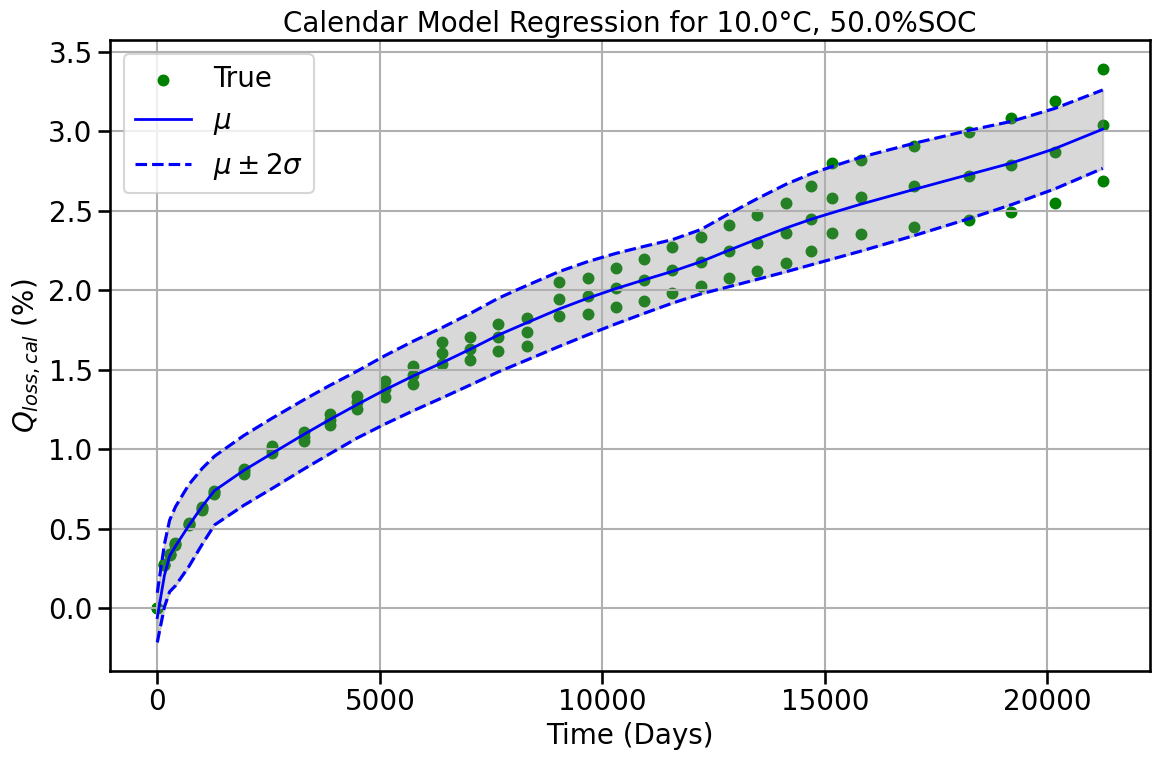

In [10]:
# condition_num = list(test_conditions.keys())[0]
condition_num = 1
condition = calendar_aging.conditions[condition_num]
Temperature_selector = calendar_aging.df_inverse['T'] == condition[0]
SOC_selector = calendar_aging.df_inverse['SOC'] == condition[1]
name = f'{condition[0]}°C, {condition[1]}%SOC'
name_true = 'True'
name_fitted = '$\mu$'
name_pm2sd = '$\mu \pm 2 \sigma$'
combined_conditions = Temperature_selector & SOC_selector
x = calendar_aging.df_inverse.loc[combined_conditions, 'Time']
y_true = calendar_aging.df_inverse.loc[combined_conditions, 'Q_loss (%)']
y_fitted = calendar_aging.df_inverse.loc[combined_conditions, 'Q_loss_predicted (%)']
y_m2sd = calendar_aging.df_inverse.loc[combined_conditions, 'Q_loss_predicted_m2sd (%)']
y_p2sd = calendar_aging.df_inverse.loc[combined_conditions, 'Q_loss_predicted_p2sd (%)']

file_name = os.path.join(parent, "results\calendar", f"figures\static_{name}.svg")
plot_static_loss_with_confidence_intervals(x, y_true, y_fitted, y_m2sd, y_p2sd, name, type=calendar_aging.degradation_type, save_plot=True, save_path=file_name)